<a href="https://colab.research.google.com/github/pfbahury/AlgGenetico/blob/main/C%C3%B3pia_de_AlgGenetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicação Manual + Firebase


In [1]:
%pip install 'firebase_admin>=4.1.0'

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
from firebase_admin import firestore
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import pytz

# Carregue as credenciais do Firebase a partir do arquivo JSON baixado.
cred = credentials.Certificate("/content/db-esmanager-firebase-adminsdk-ysv9r-0ae0a8b444.json")

# Inicialize o SDK do Firebase.
firebase_admin.initialize_app(cred)



In [7]:
db = firestore.client()
colecao = db.collection('dadosMateriais')
colecao_dict = {}

# Itere sobre os documentos da coleção
documentos = colecao.stream()
for doc in documentos:
    doc_id = doc.id
    doc_data = doc.to_dict()
    colecao_dict[doc_id] = doc_data

# Agora, colecao_dict contém os documentos da coleção como um dicionário
#print(colecao_dict)


In [ ]:
colecao_dict

In [9]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import pytz

# Crie widgets para entrada de data de início e término
data_inicio_widget = widgets.DatePicker(description='Data de início:')
data_fim_widget = widgets.DatePicker(description='Data de término:')

# Função para filtrar e salvar os dados no novo dicionário
dados_filtrados = {}  # Novo dicionário para armazenar os dados no intervalo
def filtrar_data(sender):
    data_inicio = pd.to_datetime(data_inicio_widget.value, utc=True)
    data_fim = pd.to_datetime(data_fim_widget.value, utc=True)

    if data_inicio is not None and data_fim is not None:
        # Filtrar os dados com base no intervalo de tempo e salvá-los no novo dicionário
        dados_filtrados.clear()  # Limpar dados filtrados anteriores
        for chave, sub_dados in colecao_dict.items():
            data = sub_dados['data'].astimezone(pytz.UTC)
            if data_inicio <= data <= data_fim:
                dados_filtrados[chave] = sub_dados

# Associe a função de filtragem ao evento de alteração de widgets
data_inicio_widget.observe(filtrar_data, names='value')
data_fim_widget.observe(filtrar_data, names='value')

# Exiba os widgets
display(data_inicio_widget)
display(data_fim_widget)

DatePicker(value=None, description='Data de início:')

DatePicker(value=None, description='Data de término:')

In [ ]:

class Produto():
    def __init__(self, nome, volume, peso):
        self.nome = nome
        self.volume = volume
        self.peso = peso

dados = colecao_dict
lista_produtos = []

for chave, valor in dados.items():
   if 'nome' in valor:
    produto = Produto(valor['nome'], valor['volume'], valor['peso'])
    lista_produtos.append(produto)

# Agora, você tem uma lista de objetos da classe Produto
print("Lista de Produtos:")
for produto in lista_produtos:
    print(f"Nome: {produto.nome}, Volume: {produto.volume}, Peso: {produto.peso}")


In [ ]:
from random import random
import matplotlib.pyplot as plt

class Produto():
    def __init__(self, nome, espaco, valor):
        self.nome = nome
        self.espaco = espaco
        self.valor = valor

class Individuo():
    def __init__(self, espacos, valores, limite_espacos, geracao=0):
        self.espacos = espacos
        self.valores = valores
        self.limite_espacos = limite_espacos
        self.nota_avaliacao = 0
        self.espaco_usado = 0
        self.geracao = geracao
        self.cromossomo = []

        for i in range(len(espacos)):
            if random() < 0.5:
                self.cromossomo.append("0")
            else:
                self.cromossomo.append("1")

    def avaliacao(self):
        nota = 0
        soma_espacos = 0
        for i in range(len(self.cromossomo)):
           if self.cromossomo[i] == '1':
               nota += self.valores[i]
               soma_espacos += self.espacos[i]
        if soma_espacos > self.limite_espacos:
            nota = 1
        self.nota_avaliacao = nota
        self.espaco_usado = soma_espacos

    def crossover(self, outro_individuo):
        corte = round(random()  * len(self.cromossomo))

        filho1 = outro_individuo.cromossomo[0:corte] + self.cromossomo[corte::]
        filho2 = self.cromossomo[0:corte] + outro_individuo.cromossomo[corte::]

        filhos = [Individuo(self.espacos, self.valores, self.limite_espacos, self.geracao + 1),
                  Individuo(self.espacos, self.valores, self.limite_espacos, self.geracao + 1)]
        filhos[0].cromossomo = filho1
        filhos[1].cromossomo = filho2
        return filhos

    def mutacao(self, taxa_mutacao):
        #print("Antes %s " % self.cromossomo)
        for i in range(len(self.cromossomo)):
            if random() < taxa_mutacao:
                if self.cromossomo[i] == '1':
                    self.cromossomo[i] = '0'
                else:
                    self.cromossomo[i] = '1'
        #print("Depois %s " % self.cromossomo)
        return self

class AlgoritmoGenetico():
    def __init__(self, tamanho_populacao):
        self.tamanho_populacao = tamanho_populacao
        self.populacao = []
        self.geracao = 0
        self.melhor_solucao = 0
        self.lista_solucoes = []

    def inicializa_populacao(self, espacos, valores, limite_espacos):
        for i in range(self.tamanho_populacao):
            self.populacao.append(Individuo(espacos, valores, limite_espacos))
        self.melhor_solucao = self.populacao[0]

    def ordena_populacao(self):
        self.populacao = sorted(self.populacao,
                                key = lambda populacao: populacao.nota_avaliacao,
                                reverse = True)

    def melhor_individuo(self, individuo):
        if individuo.nota_avaliacao > self.melhor_solucao.nota_avaliacao:
            self.melhor_solucao = individuo

    def soma_avaliacoes(self):
        soma = 0
        for individuo in self.populacao:
           soma += individuo.nota_avaliacao
        return soma

    def seleciona_pai(self, soma_avaliacao):
        pai = -1
        valor_sorteado = random() * soma_avaliacao
        soma = 0
        i = 0
        while i < len(self.populacao) and soma < valor_sorteado:
            soma += self.populacao[i].nota_avaliacao
            pai += 1
            i += 1
        return pai

    def visualiza_geracao(self):
        melhor = self.populacao[0]
        print("G:%s -> Valor: %s Espaço: %s Cromossomo: %s" % (self.populacao[0].geracao,
                                                               melhor.nota_avaliacao,
                                                               melhor.espaco_usado,
                                                               melhor.cromossomo))

    def resolver(self, taxa_mutacao, numero_geracoes, espacos, valores, limite_espacos):
        self.inicializa_populacao(espacos, valores, limite_espacos)

        for individuo in self.populacao:
            individuo.avaliacao()

        self.ordena_populacao()
        self.melhor_solucao = self.populacao[0]
        self.lista_solucoes.append(self.melhor_solucao.nota_avaliacao)

        self.visualiza_geracao()

        for geracao in range(numero_geracoes):
            soma_avaliacao = self.soma_avaliacoes()
            nova_populacao = []

            for individuos_gerados in range(0, self.tamanho_populacao, 2):
                pai1 = self.seleciona_pai(soma_avaliacao)
                pai2 = self.seleciona_pai(soma_avaliacao)

                filhos = self.populacao[pai1].crossover(self.populacao[pai2])

                nova_populacao.append(filhos[0].mutacao(taxa_mutacao))
                nova_populacao.append(filhos[1].mutacao(taxa_mutacao))

            self.populacao = list(nova_populacao)

            for individuo in self.populacao:
                individuo.avaliacao()

            self.ordena_populacao()

            self.visualiza_geracao()

            melhor = self.populacao[0]
            self.lista_solucoes.append(melhor.nota_avaliacao)
            self.melhor_individuo(melhor)

        print("\nMelhor solução -> G: %s Valor: %s Espaço: %s Cromossomo: %s" %
              (self.melhor_solucao.geracao,
               self.melhor_solucao.nota_avaliacao,
               self.melhor_solucao.espaco_usado,
               self.melhor_solucao.cromossomo))

        return self.melhor_solucao.cromossomo


if __name__ == '__main__':
    #p1 = Produto("Iphone 6", 0.0000899, 2199.12)
    db = firestore.client()
    colecao = db.collection('dadosMateriais')
    colecao_dict = {}

    # Itere sobre os documentos da coleção
    documentos = colecao.stream()
    for doc in documentos:
        doc_id = doc.id
        doc_data = doc.to_dict()
        colecao_dict[doc_id] = doc_data

    dados_firebase = dados_filtrados


if dados_firebase:
    lista_produtos = []
    # Itera sobre os produtos e extrai os nomes
    for chave, valor in dados_firebase.items():
      if 'nome' in valor:
        produto = Produto(valor['nome'], valor['volume'], valor['peso'])
        lista_produtos.append(produto)

    espacos = []
    valores = []
    nomes = []
    for produto in lista_produtos:
        espacos.append(produto.espaco)
        valores.append(produto.valor)
        nomes.append(produto.nome)
    limite = 100
    tamanho_populacao = 70
    taxa_mutacao = 0.01
    numero_geracoes = 100
    ag = AlgoritmoGenetico(tamanho_populacao)
    resultado = ag.resolver(taxa_mutacao, numero_geracoes, espacos, valores, limite)
    for i in range(len(lista_produtos)):
        if resultado[i] == '1':
            print("Nome: %s, %s Kg" % (lista_produtos[i].nome,
                                       lista_produtos[i].valor))


    #for valor in ag.lista_solucoes:
    #    print(valor)
    plt.plot(ag.lista_solucoes)
    plt.title("Acompanhamento dos valores")
    plt.show()

# Biblioteca DEAP

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max     	min  	med     	std      
0  	20    	0.179957	1e-05	0.101919	0.0631542
1  	20    	0.174468	1e-05	0.126387	0.0503436
2  	20    	0.201135	0.081988	0.146736	0.0300354
3  	20    	0.201135	0.0758736	0.15659 	0.0289925
4  	20    	0.201135	1e-05    	0.14858 	0.0424552
5  	20    	0.203435	0.0754589	0.159413	0.0334535
6  	20    	0.201135	0.120064 	0.166403	0.0235223
7  	20    	0.201135	0.132666 	0.171335	0.0253185
8  	20    	0.201135	0.117675 	0.178608	0.0269696
9  	20    	0.205434	0.156137 	0.193052	0.0147637
10 	20    	0.205434	0.168858 	0.192223	0.0119428
11 	20    	0.205434	0.168858 	0.196026	0.0105019
12 	20    	0.201135	0.176136 	0.194716	0.0102734
13 	20    	0.201135	0.171945 	0.194925	0.010853 
14 	20    	0.201135	0.176136 	0.198635	0.0074997
15 	20    	0.201135	0.176136 	0.199885	0.00544841
16 	20    	0.201135	0.201135 	0.201135	2.77556e-17
17 	20    	0.201135	0.201135 	0.201135	2.77556e-17
18 	20    	0.201135	0.201135 	0.201135	2.77556e-17
19 	20    	0.201135	0.2011

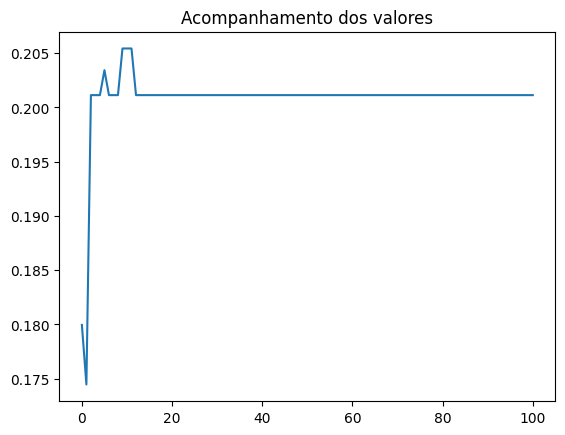

In [ ]:
!pip install deap
import random
import numpy
from deap import base
from deap import creator
from deap import algorithms
from deap import tools
import matplotlib.pyplot as plt

class Produto():
    def __init__(self, nome, espaco, valor):
        self.nome = nome
        self.espaco = espaco
        self.valor = valor

lista_produtos = []
lista_produtos.append(Produto("Geladeira Dako", 0.751, 999.90))
lista_produtos.append(Produto("Iphone 6", 0.0000899, 2911.12))
lista_produtos.append(Produto("TV 55' ", 0.400, 4346.99))
lista_produtos.append(Produto("TV 50' ", 0.290, 3999.90))
lista_produtos.append(Produto("TV 42' ", 0.200, 2999.00))
lista_produtos.append(Produto("Notebook Dell", 0.00350, 2499.90))
lista_produtos.append(Produto("Ventilador Panasonic", 0.496, 199.90))
lista_produtos.append(Produto("Microondas Electrolux", 0.0424, 308.66))
lista_produtos.append(Produto("Microondas LG", 0.0544, 429.90))
lista_produtos.append(Produto("Microondas Panasonic", 0.0319, 299.29))
lista_produtos.append(Produto("Geladeira Brastemp", 0.635, 849.00))
lista_produtos.append(Produto("Geladeira Consul", 0.870, 1199.89))
lista_produtos.append(Produto("Notebook Lenovo", 0.498, 1999.90))
lista_produtos.append(Produto("Notebook Asus", 0.527, 3999.00))

espacos = []
valores = []
nomes = []
for produto in lista_produtos:
    espacos.append(produto.espaco)
    valores.append(produto.valor)
    nomes.append(produto.nome)
limite = 3

toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def avaliacao(individual):
    nota = 0
    soma_espacos = 0
    for i in range(len(individual)):
       if individual[i] == 1:
           nota += valores[i]
           soma_espacos += espacos[i]
    if soma_espacos > limite:
        nota = 1
    return nota / 100000,

toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.01)
toolbox.register("select", tools.selRoulette)

if __name__ == "__main__":
    random.seed(1)
    populacao = toolbox.population(n = 20)
    probabilidade_crossover = 1.0
    probabilidade_mutacao = 0.01
    numero_geracoes = 100

    estatisticas = tools.Statistics(key=lambda individuo: individuo.fitness.values)
    estatisticas.register("max", numpy.max)
    estatisticas.register("min", numpy.min)
    estatisticas.register("med", numpy.mean)
    estatisticas.register("std", numpy.std)

    populacao, info = algorithms.eaSimple(populacao, toolbox,
                                          probabilidade_crossover,
                                          probabilidade_mutacao,
                                          numero_geracoes, estatisticas)
    melhores = tools.selBest(populacao, 1)
    for individuo in melhores:
        print(individuo)
        print(individuo.fitness)
        #print(individuo[1])
        soma = 0
        for i in range(len(lista_produtos)):
            if individuo[i] == 1:
                soma += valores[i]
                print("Nome: %s R$ %s " % (lista_produtos[i].nome,
                                           lista_produtos[i].valor))
        print("Melhor solução: %s" % soma)

    valores_grafico = info.select("max")
    plt.plot(valores_grafico)
    plt.title("Acompanhamento dos valores")
    plt.show()
